In [6]:
import random

import numpy as np
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score

from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split

# Установка seed для стандартного генератора случайных чисел Python
random.seed(42)

# Установка seed для NumPy (если используете его)
np.random.seed(42)

# Установка seed для PyTorch
torch.manual_seed(42)

# Если используете CUDA
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)  # Если у вас несколько GPU

# Для обеспечения полной повторяемости (этот шаг замедляет выполнение на GPU)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Data
subj_path = "..\\data\\Fedor\\Raw\\preproc_angles\\1\\"
fs = 500


def corrcoef(x, y):
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0
    return np.corrcoef(x, y)[0, 1]


def train_test_split(data, N_parts, num_of_part):
    N_samples = len(data)

    l_idx = int((N_samples * num_of_part) / N_parts)
    h_idx = int((N_samples * (num_of_part + 1)) / N_parts)

    data_train = np.concatenate([data[:l_idx, :], data[h_idx:,]], axis=0)
    data_test = data[l_idx:h_idx, :]

    return data_train, data_test


N_files = 4
data_list_train = list()
data_list_test = list()
label_list_train = list()
label_list_test = list()

N_parts = 10
num_of_part = 9

for i in range(N_files):

    arr = np.load(subj_path + "000" + str(i) + ".npz")

    std_coef = arr["std_coef"]
    data = arr["data_myo"]
    label = arr["data_angles"]

    data_train, data_test = train_test_split(data, N_parts, num_of_part)
    label_train, label_test = train_test_split(label, N_parts, num_of_part)

    data_list_train.append(data_train)
    data_list_test.append(data_test)

    label_list_train.append(label_train)
    label_list_test.append(label_test)


data_train = np.concatenate(data_list_train, axis=0)
data_test = np.concatenate(data_list_test, axis=0)


label_train = np.concatenate(label_list_train, axis=0)
label_test = np.concatenate(label_list_test, axis=0)


def slicer(data, label, fs, windowlen=500, timestep=100):
    data_len = len(data)
    timestep_samples = int((timestep * fs) / 1000)
    windowlen_samples = int((windowlen * fs) / 1000)
    start_idc = np.arange(0, data_len - windowlen_samples, timestep_samples)[:, None]
    window_idc = np.arange(0, windowlen_samples)[None, :]
    slice_idc = start_idc + window_idc
    slice_data = data[slice_idc].transpose(0, 2, 1)
    slice_label = label[start_idc[:, 0] + windowlen_samples]
    return slice_data, slice_label


X_train, y_train = slicer(data_train, label_train, fs, windowlen=256, timestep=200)
X_test, y_test = slicer(data_test, label_test, fs, windowlen=256, timestep=200)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1599, 6, 128), (177, 6, 128), (1599, 20), (177, 20))

In [22]:
# Data
subj_path = "..\\data\\Alexander Chevcov\\Simple(6 electrodes)\\Preprocessed\\Simple2\\"
fs = 500
n_channels = 6


def corrcoef(x, y):
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0
    return np.corrcoef(x, y)[0, 1]


def train_test_split(data, N_parts, num_of_part):
    N_samples = len(data)

    l_idx = int((N_samples * num_of_part) / N_parts)
    h_idx = int((N_samples * (num_of_part + 1)) / N_parts)

    data_train = np.concatenate([data[:l_idx, :], data[h_idx:,]], axis=0)
    data_test = data[l_idx:h_idx, :]

    return data_train, data_test


N_files = 8
data_list_train = list()
data_list_test = list()
label_list_train = list()
label_list_test = list()

N_parts = 10
num_of_part = 9

for i in range(N_files):

    arr = np.load(subj_path + "000" + str(i) + ".npz")

    std_coef = arr["std_coef"]
    data = arr["data_myo"]
    label = arr["data_angles"]

    data = data[:, :n_channels]

    data_train, data_test = train_test_split(data, N_parts, num_of_part)
    label_train, label_test = train_test_split(label, N_parts, num_of_part)

    data_list_train.append(data_train)
    data_list_test.append(data_test)

    label_list_train.append(label_train)
    label_list_test.append(label_test)


data_train = np.concatenate(data_list_train, axis=0)
data_test = np.concatenate(data_list_test, axis=0)


label_train = np.concatenate(label_list_train, axis=0)
label_test = np.concatenate(label_list_test, axis=0)


def slicer(data, label, fs, windowlen=500, timestep=100):
    data_len = len(data)
    timestep_samples = int((timestep * fs) / 1000)
    windowlen_samples = int((windowlen * fs) / 1000)
    start_idc = np.arange(0, data_len - windowlen_samples, timestep_samples)[:, None]
    window_idc = np.arange(0, windowlen_samples)[None, :]
    slice_idc = start_idc + window_idc
    slice_data = data[slice_idc].transpose(0, 2, 1)
    slice_label = label[start_idc[:, 0] + windowlen_samples]
    return slice_data, slice_label


X_train, y_train = slicer(data_train, label_train, fs, windowlen=256, timestep=200)
X_test, y_test = slicer(data_test, label_test, fs, windowlen=256, timestep=200)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3199, 6, 128), (355, 6, 128), (3199, 20), (355, 20))

In [4]:
# ---------------- PREPROCESSING FUNCTIONS ----------------


def train_test_split(data, N_parts, num_of_part):
    N_samples = len(data)
    l_idx = int((N_samples * num_of_part) / N_parts)
    h_idx = int((N_samples * (num_of_part + 1)) / N_parts)
    data_train = np.concatenate([data[:l_idx], data[h_idx:]], axis=0)
    data_test = data[l_idx:h_idx]
    return data_train, data_test


def slicer(data, label, fs, windowlen=500, timestep=100):
    data_len = len(data)
    timestep_samples = int((timestep * fs) / 1000)
    windowlen_samples = int((windowlen * fs) / 1000)
    start_idc = np.arange(0, data_len - windowlen_samples, timestep_samples)[:, None]
    window_idc = np.arange(0, windowlen_samples)[None, :]
    slice_idc = start_idc + window_idc
    slice_data = data[slice_idc].transpose(0, 2, 1)
    slice_label = label[start_idc[:, 0] + windowlen_samples]
    return slice_data, slice_label


# ---------------- SEQUENCE PREPARATION ----------------


def prepare_sequences(X, y, seq_len):
    n_samples, feat_dim = X.shape
    _, out_dim = y.shape
    n_seq = n_samples - seq_len
    X_seq = np.zeros((n_seq, seq_len, feat_dim), dtype=X.dtype)
    y_seq = np.zeros((n_seq, seq_len, out_dim), dtype=y.dtype)
    for i in range(n_seq):
        X_seq[i] = X[i : i + seq_len]
        y_seq[i] = y[i : i + seq_len]
    return X_seq, y_seq


def prepare_single_sequence(X, seq_len):
    n_samples, feat_dim = X.shape
    if n_samples < seq_len:
        pad = np.zeros((seq_len - n_samples, feat_dim), dtype=X.dtype)
        seq = np.vstack([pad, X])
    else:
        seq = X[-seq_len:]
    return seq[np.newaxis, ...]

In [24]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


class TorchAutoRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, dropout=0.0):
        super().__init__()
        self.output_dim = output_dim
        self.lstm = nn.LSTM(
            input_dim + output_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
        )
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x_seq, y_prev=None, teacher_forcing=False):
        batch, seq_len, _ = x_seq.shape
        device = x_seq.device
        outputs = []
        h, c = None, None
        y_t = torch.zeros(batch, self.output_dim, device=device)
        for t in range(seq_len):
            x_t = x_seq[:, t]
            inp = torch.cat([x_t, y_t], dim=-1).unsqueeze(1)
            out_lstm, (h, c) = self.lstm(inp, (h, c) if h is not None else None)
            y_pred = self.mlp(out_lstm[:, 0])
            outputs.append(y_pred.unsqueeze(1))
            y_t = y_prev[:, t] if (teacher_forcing and y_prev is not None) else y_pred
        return torch.cat(outputs, dim=1)


class RiemannAutoRegressor(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        estimator="oas",
        metric="riemann",
        hidden_dim=128,
        seq_len=10,
        num_layers=1,
        alpha=1e-5,
        lr=1e-3,
        max_iter=1,
        batch_size=32,
        device="cpu",
        verbose=False,
    ):
        self.estimator = estimator
        self.metric = metric
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.num_layers = num_layers
        self.alpha = alpha
        self.lr = lr
        self.max_iter = max_iter
        self.batch_size = batch_size
        self.device = device
        self.verbose = verbose
        self.cov_ = None
        self.ts_ = None
        self.model_ = None

    def fit(self, X, y, X_val=None, y_val=None):
        # 1) Riemannian features
        self.cov_ = Covariances(estimator=self.estimator)
        X_cov = self.cov_.fit_transform(X)
        self.ts_ = TangentSpace(metric=self.metric)
        X_ts = self.ts_.fit_transform(X_cov)

        # Validation transforms
        if X_val is not None and y_val is not None:
            X_cov_val = self.cov_.transform(X_val)
            X_ts_val = self.ts_.transform(X_cov_val)

        # 2) Autoregressive sequences
        X_seq, y_seq = prepare_sequences(X_ts, y, self.seq_len)
        if X_val is not None and y_val is not None:
            X_seq_val, y_seq_val = prepare_sequences(X_ts_val, y_val, self.seq_len)

        # to tensors
        X_seq = torch.tensor(X_seq, dtype=torch.float32).to(self.device)
        y_seq = torch.tensor(y_seq, dtype=torch.float32).to(self.device)
        if X_val is not None and y_val is not None:
            X_seq_val = torch.tensor(X_seq_val, dtype=torch.float32).to(self.device)
            y_seq_val = torch.tensor(y_seq_val, dtype=torch.float32).to(self.device)

        print(X_seq_val.shape)
        print(y_seq_val.shape)

        # dims
        _, seq_len, feat_dim = X_seq.shape
        _, _, out_dim = y_seq.shape

        # 3) Model init
        self.model_ = TorchAutoRegressor(
            input_dim=feat_dim,
            hidden_dim=self.hidden_dim,
            output_dim=out_dim,
            num_layers=self.num_layers,
        ).to(self.device)
        optimizer = optim.Adam(
            self.model_.parameters(), lr=self.lr, weight_decay=self.alpha
        )
        criterion = nn.MSELoss()
        loader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(X_seq, y_seq),
            batch_size=self.batch_size,
            shuffle=True,
        )

        # Training loop
        for epoch in range(1, self.max_iter + 1):

            # train
            self.model_.train()
            total_loss = 0.0
            for xb, yb in loader:
                optimizer.zero_grad()
                out = self.model_(xb, y_prev=yb, teacher_forcing=True)
                loss = criterion(out, yb)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

            # metrics
            if self.verbose and epoch % 10 == 0:
                avg_train_loss = total_loss / len(loader)

                # train corr
                self.model_.eval()
                with torch.no_grad():
                    pred_train = self.model_(X_seq, teacher_forcing=False).cpu().numpy()
                y_train_np = y_seq.cpu().numpy()
                train_corrs = [
                    corrcoef(pred_train[:, :, i].ravel(), y_train_np[:, :, i].ravel())
                    for i in range(out_dim)
                ]
                train_mean_corr = np.nanmean(train_corrs)
                msg = f"Epoch {epoch}/{self.max_iter} Train Loss: {avg_train_loss:.4f}, Train Corr: {train_mean_corr:.3f}"

                # val metrics
                if X_val is not None and y_val is not None:
                    with torch.no_grad():
                        pred_val = (
                            self.model_(X_seq_val, teacher_forcing=False).cpu().numpy()
                        )
                    y_val_np = y_seq_val.cpu().numpy()
                    val_loss = criterion(
                        torch.tensor(pred_val), torch.tensor(y_val_np)
                    ).item()
                    val_corrs = [
                        corrcoef(pred_val[:, :, i].ravel(), y_val_np[:, :, i].ravel())
                        for i in range(out_dim)
                    ]
                    val_mean_corr = np.nanmean(val_corrs)
                    msg += f", Val Loss: {val_loss:.4f}, Val Corr: {val_mean_corr:.3f}"
                print(msg)
        return self

    def validate(self, X, y):
        X_cov = self.cov_.transform(X)
        X_ts = self.ts_.transform(X_cov)
        X_seq, y_seq = prepare_sequences(X_ts, y, self.seq_len)
        X_seq = torch.tensor(X_seq, dtype=torch.float32).to(self.device)
        self.model_.eval()
        with torch.no_grad():
            out_seq = self.model_(X_seq, teacher_forcing=False)
        return out_seq.cpu().numpy()

    def predict(self, X):
        X_cov = self.cov_.transform(X)
        X_ts = self.ts_.transform(X_cov)
        X_seq = prepare_single_sequence(X_ts, self.seq_len)
        X_seq = torch.tensor(X_seq, dtype=torch.float32).to(self.device)
        # print(f"X_seq.shape: {X_seq.shape}")
        self.model_.eval()
        with torch.no_grad():
            out_seq = self.model_(X_seq, teacher_forcing=False)
        return out_seq.cpu().numpy()


model = RiemannAutoRegressor(
    estimator="oas",
    metric="riemann",
    hidden_dim=128,
    seq_len=10,
    num_layers=1,
    alpha=1e-5,
    lr=1e-3,
    max_iter=70,
    batch_size=64,
    device="cuda",
    verbose=True,
)
model.fit(X_train, y_train, X_test, y_test)

torch.Size([345, 10, 21])
torch.Size([345, 10, 20])
Epoch 10/70 Train Loss: 0.0106, Train Corr: 0.896, Val Loss: 0.0425, Val Corr: 0.809
Epoch 20/70 Train Loss: 0.0078, Train Corr: 0.919, Val Loss: 0.0340, Val Corr: 0.841
Epoch 30/70 Train Loss: 0.0066, Train Corr: 0.930, Val Loss: 0.0350, Val Corr: 0.842
Epoch 40/70 Train Loss: 0.0061, Train Corr: 0.933, Val Loss: 0.0359, Val Corr: 0.847
Epoch 50/70 Train Loss: 0.0057, Train Corr: 0.938, Val Loss: 0.0370, Val Corr: 0.846
Epoch 60/70 Train Loss: 0.0052, Train Corr: 0.943, Val Loss: 0.0345, Val Corr: 0.854
Epoch 70/70 Train Loss: 0.0049, Train Corr: 0.944, Val Loss: 0.0353, Val Corr: 0.855


RiemannAutoRegressor(batch_size=64, device='cuda', max_iter=70, verbose=True)

In [ ]:
y_pred = []
for i in range(len(X_test)):
    # берем все окна до i-го включительно,
    # чтобы модель имела предыдущие seq_len шагов
    # (prepare_single_sequence внутри predict сама допадит нулями, если данных < seq_len).
    input_seq = X_test[: i + 1]
    # print("input_seq shape:", input_seq.shape)
    # model.predict возвращает массив формы (1, seq_len, out_dim)
    seq_pred = model.predict(input_seq)
    # берем последний шаг предсказанной последовательности
    y_t = seq_pred[0, -1, :]  # (out_dim,)
    y_pred.append(y_t)

In [25]:
# 1) вспомогательная функция корреляции
def corrcoef_flat(x, y):
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0
    return np.corrcoef(x, y)[0, 1]


# 2) делаем предсказания для каждого окна
y_pred = []
for i in range(len(X_test)):
    # берем все окна до i-го включительно,
    # чтобы модель имела предыдущие seq_len шагов
    # (prepare_single_sequence внутри predict сама допадит нулями, если данных < seq_len).
    input_seq = X_test[: i + 1]
    # print("input_seq shape:", input_seq.shape)
    # model.predict возвращает массив формы (1, seq_len, out_dim)
    seq_pred = model.predict(input_seq)
    # берем последний шаг предсказанной последовательности
    y_t = seq_pred[0, -1, :]  # (out_dim,)
    y_pred.append(y_t)

y_pred = np.stack(y_pred, axis=0)  # (177, 20)

# 3) считаем корреляцию по каждому из 20 каналов
# corrs = []
# for chan in range(y_test.shape[1]):
#     c = corrcoef_flat(y_pred[:, chan], y_test[:, chan])
#     corrs.append(c)

corrs = []
r2s   = []
for chan in range(y_test.shape[1]):
    y_true_chan = y_test[:, chan]
    y_pred_chan = y_pred[:, chan]

    # Pearson correlation
    c = corrcoef_flat(y_pred_chan, y_true_chan)
    corrs.append(c)

    # R2 score
    # если все значения y_true одинаковы, r2_score вернёт ValueError,
    # можно в этом случае руками положить 0.0
    if np.allclose(y_true_chan, y_true_chan[0]):
        r2 = 0.0
    else:
        r2 = r2_score(y_true_chan, y_pred_chan)
    r2s.append(r2)

mean_corr = np.nanmean(corrs)
mean_r2   = np.nanmean(r2s)

# 4) вывод результатов
print("y_pred shape:", y_pred.shape)  # (177, 20)
print("Channel-wise correlations:", [f"{c:.3f}" for c in corrs])
print("Mean correlation:        ", f"{mean_corr:.3f}")
print("Channel-wise R2 scores:  ", [f"{r:.3f}" for r in r2s])
print("Mean R2 score:           ", f"{mean_r2:.3f}")

y_pred shape: (355, 20)
Channel-wise correlations: ['0.809', '0.685', '0.849', '0.863', '0.867', '0.901', '0.868', '0.874', '0.927', '0.832', '0.887', '0.893', '0.973', '0.869', '0.908', '0.890', '0.850', '0.709', '0.847', '0.861']
Mean correlation:         0.858
Channel-wise R2 scores:   ['0.633', '0.454', '0.691', '0.730', '0.741', '0.804', '0.727', '0.750', '0.858', '0.675', '0.759', '0.784', '0.945', '0.746', '0.793', '0.780', '0.698', '0.498', '0.710', '0.734']
Mean R2 score:            0.725


In [26]:
results = {}

results["model"] = {
    "all_correlations": corrs,
    "mean_correlation": np.nanmean(corrs),
    "std_correlation": np.nanstd(corrs),
    "all_r2": r2s,
    "mean_r2": np.nanmean(r2s),
    "std_r2": np.nanstd(r2s),
}

for name, metrics in results.items():
    print(f"{name}:")
    print(
        f'  Mean correlation: {metrics["mean_correlation"]:.3f} ± {metrics["std_correlation"]:.3f}'
    )
    print(
        f'  Individual correlations: {[f"{c:.3f}" for c in metrics["all_correlations"]]}\n'
    )
    print(
        f'  Mean R2: {metrics["mean_r2"]:.3f} ± {metrics["std_r2"]:.3f}'
    )
    print(
        f'  Individual R2: {[f"{r2:.3f}" for r2 in metrics["all_r2"]]}\n'
    )

model:
  Mean correlation: 0.858 ± 0.064
  Individual correlations: ['0.809', '0.685', '0.849', '0.863', '0.867', '0.901', '0.868', '0.874', '0.927', '0.832', '0.887', '0.893', '0.973', '0.869', '0.908', '0.890', '0.850', '0.709', '0.847', '0.861']

  Mean R2: 0.725 ± 0.106
  Individual R2: ['0.633', '0.454', '0.691', '0.730', '0.741', '0.804', '0.727', '0.750', '0.858', '0.675', '0.759', '0.784', '0.945', '0.746', '0.793', '0.780', '0.698', '0.498', '0.710', '0.734']



In [113]:
input_seq.shape

(355, 6, 128)

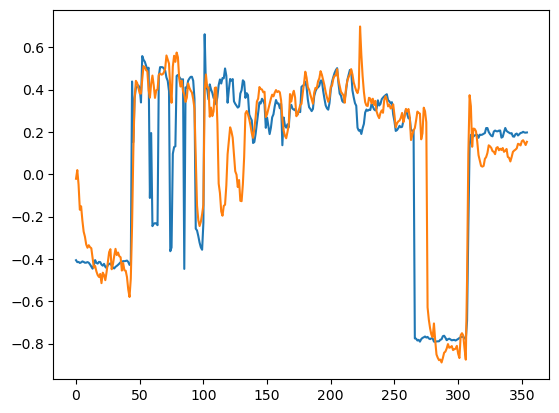

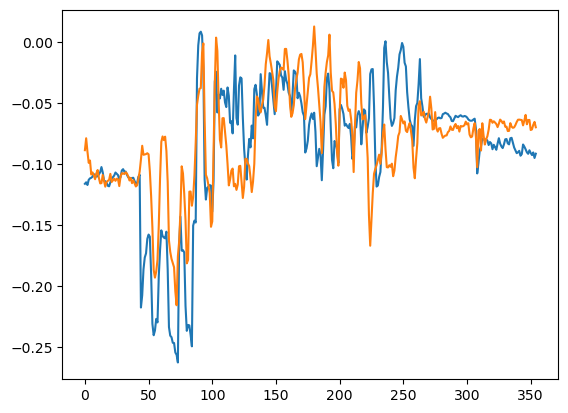

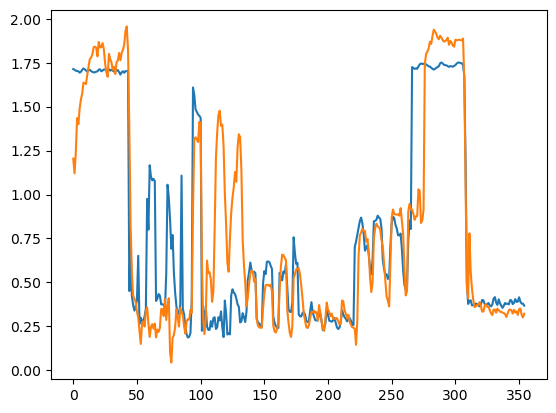

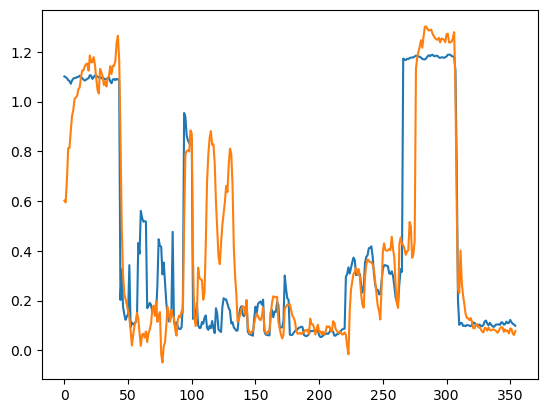

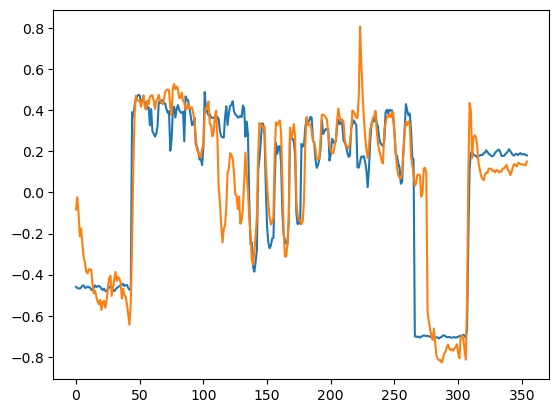

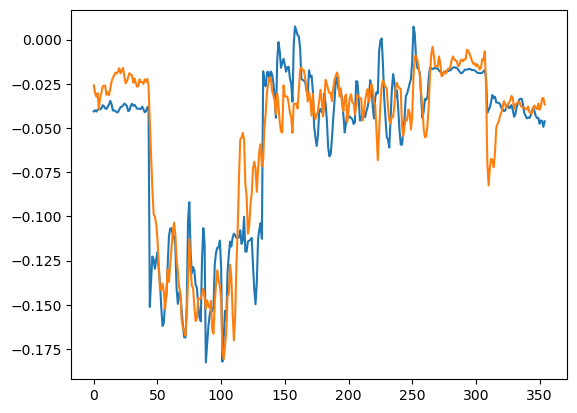

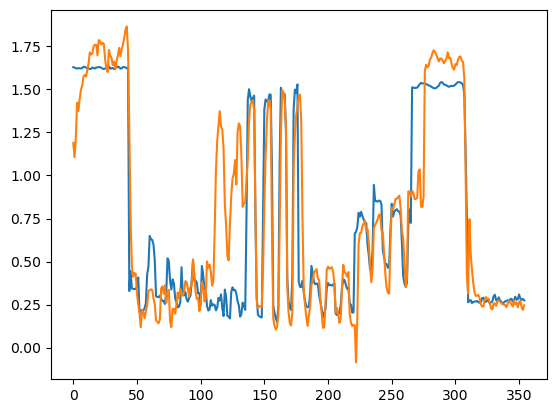

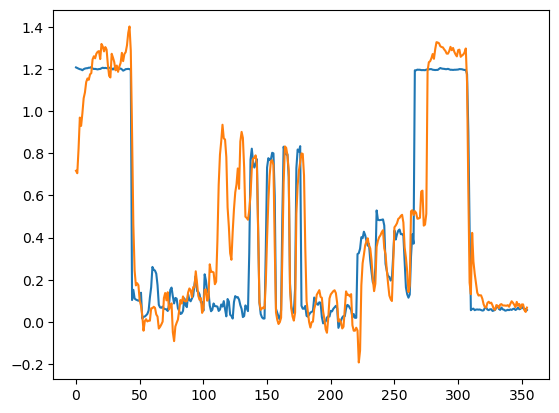

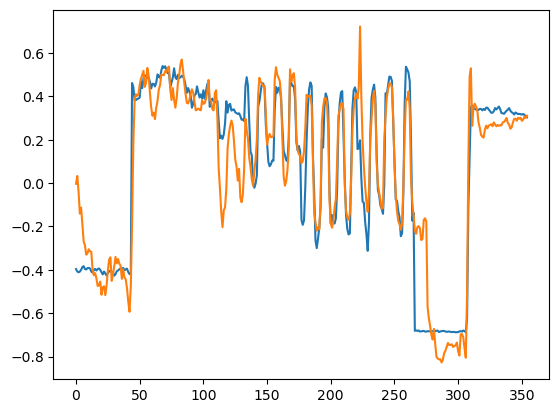

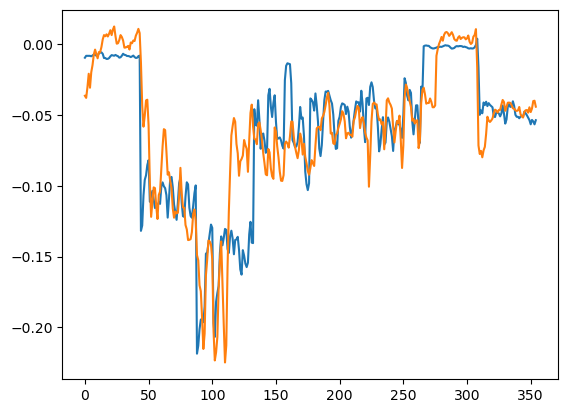

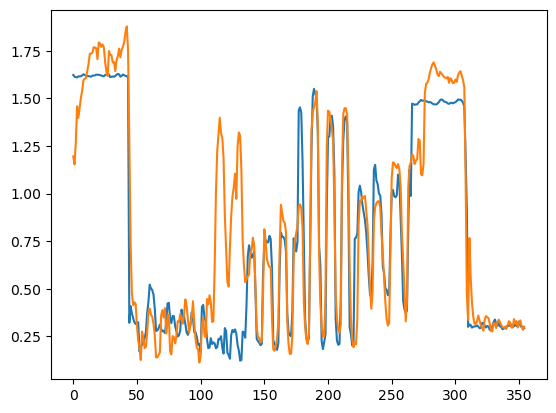

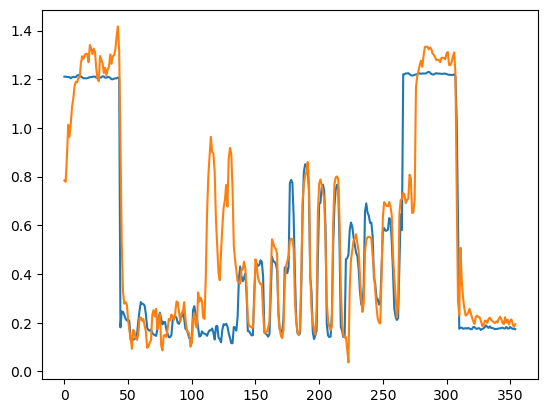

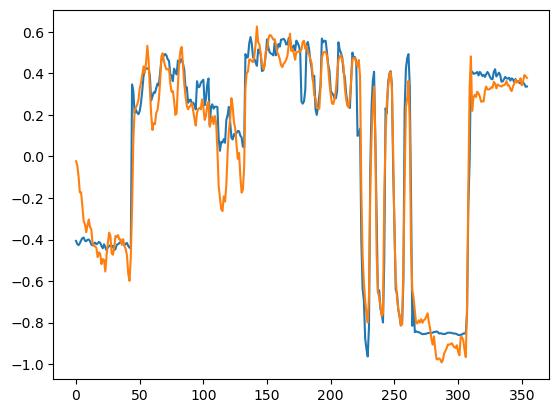

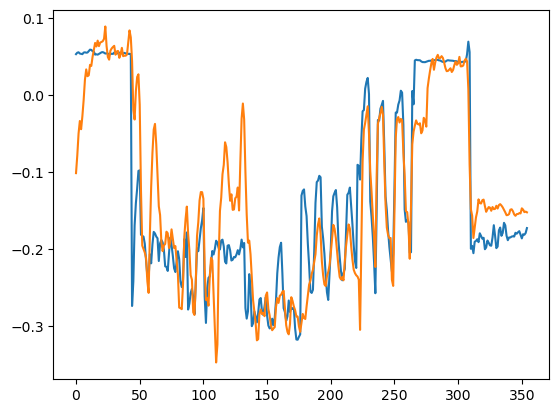

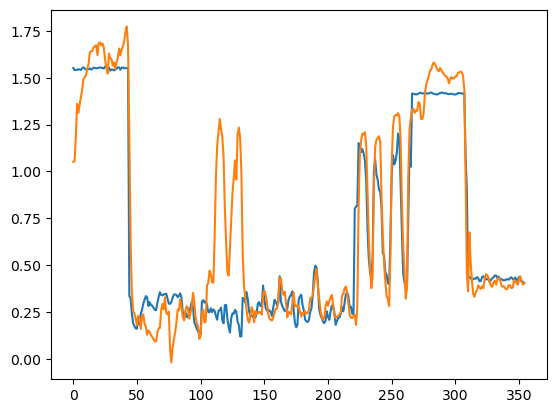

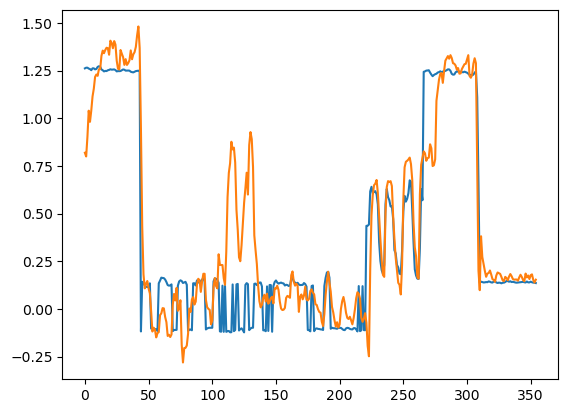

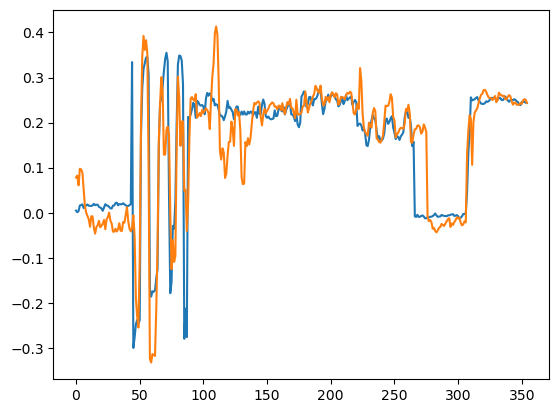

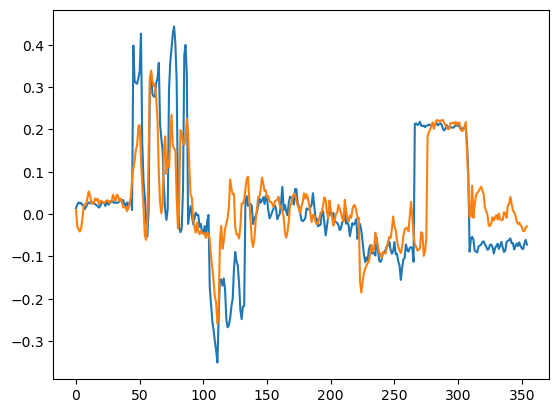

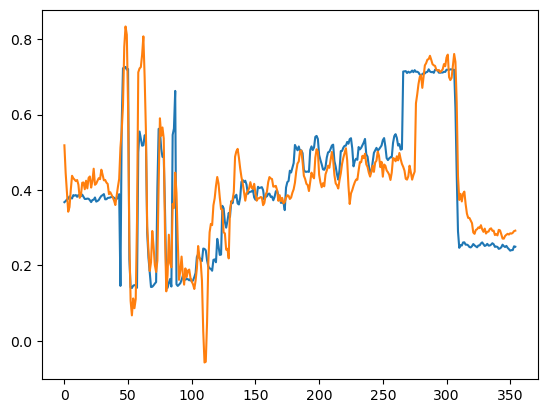

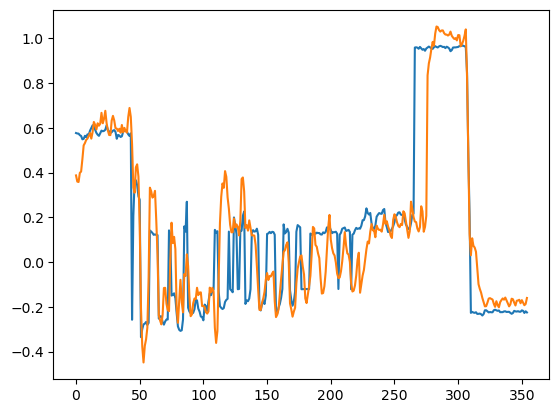

In [27]:
for i in range(y_test.shape[1]):
    plt.figure()
    plt.plot(y_test[:, i])
    plt.plot(y_pred[:, i])

In [43]:
class TorchAutoRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, dropout=0.0):
        super().__init__()
        self.output_dim = output_dim
        self.lstm = nn.LSTM(
            input_dim + output_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
        )
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x_seq, y_prev=None, teacher_forcing=False):
        batch, seq_len, _ = x_seq.shape
        device = x_seq.device
        outputs = []
        h, c = None, None
        y_t = torch.zeros(batch, self.output_dim, device=device)
        for t in range(seq_len):
            x_t = x_seq[:, t]
            inp = torch.cat([x_t, y_t], dim=-1).unsqueeze(1)
            out_lstm, (h, c) = self.lstm(inp, (h, c) if h is not None else None)
            y_pred = self.mlp(out_lstm[:, 0])
            outputs.append(y_pred.unsqueeze(1))
            y_t = y_prev[:, t] if (teacher_forcing and y_prev is not None) else y_pred
        return torch.cat(outputs, dim=1)


class RiemannAutoRegressor(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        estimator="oas",
        metric="riemann",
        hidden_dim=128,
        seq_len=10,
        num_layers=1,
        alpha=1e-5,
        lr=1e-3,
        max_iter=100,
        batch_size=32,
        device="cpu",
        verbose=False,
    ):
        self.estimator = estimator
        self.metric = metric
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.num_layers = num_layers
        self.alpha = alpha
        self.lr = lr
        self.max_iter = max_iter
        self.batch_size = batch_size
        self.device = device
        self.verbose = verbose
        self.cov_ = None
        self.ts_ = None
        self.model_ = None

    def fit(self, X, y):
        # 1) Riemannian features
        self.cov_ = Covariances(estimator=self.estimator)
        X_cov = self.cov_.fit_transform(X)
        self.ts_ = TangentSpace(metric=self.metric)
        X_ts = self.ts_.fit_transform(X_cov)

        print("X_cov.shape:", X_cov.shape)
        print("X_ts.shape:", X_ts.shape)
        print("y.shape:", y.shape)

        # 2) Autoregressive sequences
        X_seq, y_seq = prepare_sequences(X_ts, y, self.seq_len)

        print("X_seq.shape:", X_seq.shape)
        print("y_seq.shape:", y_seq.shape)

        X_seq = torch.tensor(X_seq, dtype=torch.float32).to(self.device)
        y_seq = torch.tensor(y_seq, dtype=torch.float32).to(self.device)
        _, seq_len, feat_dim = X_seq.shape
        _, _, out_dim = y_seq.shape
        # 3) Model
        self.model_ = TorchAutoRegressor(
            input_dim=feat_dim,
            hidden_dim=self.hidden_dim,
            output_dim=out_dim,
            num_layers=self.num_layers,
        ).to(self.device)
        optimizer = optim.Adam(
            self.model_.parameters(), lr=self.lr, weight_decay=self.alpha
        )
        criterion = nn.MSELoss()
        loader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(X_seq, y_seq),
            batch_size=self.batch_size,
            shuffle=True,
        )
        # Training loop
        for epoch in range(1, self.max_iter + 1):
            self.model_.train()
            total_loss = 0
            for xb, yb in loader:
                optimizer.zero_grad()
                out = self.model_(xb, y_prev=yb, teacher_forcing=True)
                loss = criterion(out, yb)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            if self.verbose and epoch % 10 == 0:
                print(
                    f"Epoch {epoch}/{self.max_iter} Loss: {total_loss/len(loader):.4f}"
                )
        return self

    def predict(self, X):
        # 1) Riemannian features
        X_cov = self.cov_.transform(X)
        X_ts = self.ts_.transform(X_cov)

        # 2) single sequence
        X_seq = prepare_single_sequence(X_ts, self.seq_len)
        X_seq = torch.tensor(X_seq, dtype=torch.float32).to(self.device)
        # 3) autoregressive forward
        self.model_.eval()
        with torch.no_grad():
            out_seq = self.model_(X_seq, teacher_forcing=False)
        return out_seq.cpu().numpy()


model = RiemannAutoRegressor(
    estimator="oas",
    metric="riemann",
    hidden_dim=128,
    seq_len=10,
    num_layers=1,
    alpha=1e-5,
    lr=1e-3,
    max_iter=100,
    batch_size=32,
    device="cpu",
    verbose=True,
)
model.fit(X_train, y_train)

X_cov.shape: (1599, 6, 6)
X_ts.shape: (1599, 21)
y.shape: (1599, 20)
X_seq.shape: (1589, 10, 21)
y_seq.shape: (1589, 10, 20)
Epoch 10/100 Loss: 0.0046
Epoch 20/100 Loss: 0.0029
Epoch 30/100 Loss: 0.0022
Epoch 40/100 Loss: 0.0018
Epoch 50/100 Loss: 0.0015
Epoch 60/100 Loss: 0.0014
Epoch 70/100 Loss: 0.0013
Epoch 80/100 Loss: 0.0012
Epoch 90/100 Loss: 0.0011
Epoch 100/100 Loss: 0.0011


RiemannAutoRegressor(verbose=True)

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cov = Covariances(estimator="oas")
X_cov = cov.fit_transform(X_train)
ts = TangentSpace(metric="riemann")
X_ts = ts.fit_transform(X_cov)

print("X_cov.shape:", X_cov.shape)
print("X_ts.shape:", X_ts.shape)
print("y.shape:", y_train.shape)

# 2) Autoregressive sequences
seq_len = 10
X_seq, y_seq = prepare_sequences(X_ts, y_train, seq_len)

X_seq = torch.tensor(X_seq, dtype=torch.float32).to(device)
y_seq = torch.tensor(y_seq, dtype=torch.float32).to(device)
_, seq_len, feat_dim = X_seq.shape
_, _, out_dim = y_seq.shape
hidden_dim = 128
num_layers = 1

model_ = TorchAutoRegressor(
    input_dim=feat_dim,
    hidden_dim=hidden_dim,
    output_dim=out_dim,
    num_layers=num_layers,
).to(device)

X_cov.shape: (1599, 6, 6)
X_ts.shape: (1599, 21)
y.shape: (1599, 20)


In [33]:
n_samples, feat_dim = X_ts.shape
_, out_dim = y_train.shape
n_seq = n_samples - seq_len
X_seq = np.zeros((n_seq, seq_len, feat_dim), dtype=X_ts.dtype)
y_seq = np.zeros((n_seq, seq_len, out_dim), dtype=y_train.dtype)

for i in range(n_seq):
    X_seq[i] = X_ts[i : i + seq_len]
    y_seq[i] = y_train[i : i + seq_len]

In [41]:
X_ts[0]

array([ 1.64358705, -0.23727681, -0.04386122,  0.00412455, -0.0709638 ,
       -0.26395055,  2.38228933, -0.337386  , -0.14176192, -0.2605633 ,
       -0.03096146,  1.61970657, -0.1942402 , -0.30699109, -0.01986674,
        2.63622328,  0.18088524, -0.49958034,  3.38308603,  0.21076641,
        2.45148874])

In [39]:
X_seq[0]

array([[ 1.64358705e+00, -2.37276809e-01, -4.38612234e-02,
         4.12454531e-03, -7.09638004e-02, -2.63950547e-01,
         2.38228933e+00, -3.37385996e-01, -1.41761915e-01,
        -2.60563304e-01, -3.09614618e-02,  1.61970657e+00,
        -1.94240196e-01, -3.06991090e-01, -1.98667419e-02,
         2.63622328e+00,  1.80885241e-01, -4.99580341e-01,
         3.38308603e+00,  2.10766413e-01,  2.45148874e+00],
       [ 9.65203125e-01, -1.36086982e-01, -3.36915621e-02,
        -6.84868190e-02,  1.47824083e-02, -1.36514497e-01,
         1.54823310e+00, -4.62258424e-01, -5.16654675e-01,
        -3.44370574e-01,  5.78856784e-02,  9.70422307e-01,
        -2.99419309e-01, -5.16909240e-01,  1.39671774e-01,
         2.24391003e+00, -1.06928707e-01, -3.17612965e-01,
         2.43673472e+00,  2.43861437e-01,  1.60795875e+00],
       [ 7.43040159e-01,  1.27627244e-01,  3.18447851e-01,
        -1.98260873e-01, -3.65146489e-01, -8.22752208e-02,
         5.85480338e-01,  3.08336241e-02, -1.50135962e

In [32]:
y_train[0:10].shape

(10, 20)

In [21]:
i = 0
X_ts[i : i + seq_len].shape

(10, 21)

In [ ]:
def prepare_sequences(X, y, seq_len):
    """
    Преобразует плоские данные X и y в перекрывающиеся автопрегрессионные последовательности.
    X: numpy array, shape (n_samples, feat_dim)
    y: numpy array, shape (n_samples, output_dim)
    seq_len: int, длина последовательности

    Возвращает:
    X_seq: numpy array, shape (n_seq, seq_len, feat_dim)
    y_seq: numpy array, shape (n_seq, seq_len, output_dim)
    где n_seq = n_samples - seq_len
    """
    n_samples, feat_dim = X.shape
    _, out_dim = y.shape
    n_seq = n_samples - seq_len
    X_seq = np.zeros((n_seq, seq_len, feat_dim), dtype=X.dtype)
    y_seq = np.zeros((n_seq, seq_len, out_dim), dtype=y.dtype)
    for i in range(n_seq):
        X_seq[i] = X[i : i + seq_len]
        y_seq[i] = y[i : i + seq_len]
    return X_seq, y_seq


def prepare_single_sequence(X, seq_len):
    """
    Готовит единичную последовательность из последних seq_len сэмплов X.
    X: numpy array, shape (n_samples, feat_dim)
    seq_len: int

    Возвращает numpy array с формой (1, seq_len, feat_dim)
    """
    n_samples, feat_dim = X.shape
    if n_samples < seq_len:
        # дополняем нулями вперед
        pad = np.zeros((seq_len - n_samples, feat_dim), dtype=X.dtype)
        seq = np.vstack([pad, X])
    else:
        seq = X[-seq_len:]
    return seq[np.newaxis, ...]


class TorchAutoRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, dropout=0.0):
        super().__init__()
        self.output_dim = output_dim
        # LSTM: вход = [признаки + предыдущие предсказания]
        self.lstm = nn.LSTM(
            input_dim + output_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
        )
        # Голова MLP для предсказания углов
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x_seq, y_prev=None, teacher_forcing=False):
        # x_seq: (batch, seq_len, feat_dim)
        # y_prev: (batch, seq_len, output_dim)
        batch, seq_len, _ = x_seq.shape
        device = x_seq.device
        outputs = []
        h, c = None, None
        # начальное предыдущее предсказание = нули
        y_t = torch.zeros(batch, self.output_dim, device=device)
        for t in range(seq_len):
            x_t = x_seq[:, t]
            inp = torch.cat([x_t, y_t], dim=-1).unsqueeze(1)  # (batch,1,feat+out)
            out_lstm, (h, c) = self.lstm(inp, (h, c) if h is not None else None)
            y_pred = self.mlp(out_lstm[:, 0])  # (batch, output_dim)
            outputs.append(y_pred.unsqueeze(1))
            if teacher_forcing and (y_prev is not None):
                y_t = y_prev[:, t]
            else:
                y_t = y_pred
        return torch.cat(outputs, dim=1)  # (batch, seq_len, output_dim)


class RiemannAutoRegressor(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        estimator="oas",
        metric="riemann",
        hidden_dim=128,
        seq_len=10,
        num_layers=1,
        alpha=1e-5,
        lr=1e-3,
        max_iter=100,
        batch_size=32,
        device="cpu",
        verbose=False,
    ):
        self.estimator = estimator
        self.metric = metric
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.num_layers = num_layers
        self.alpha = alpha
        self.lr = lr
        self.max_iter = max_iter
        self.batch_size = batch_size
        self.device = device
        self.verbose = verbose
        self.cov_ = None
        self.ts_ = None
        self.model_ = None

    def fit(self, X, y):
        # X: (n_samples, n_channels, n_times)
        # y: (n_samples, output_dim)
        # Шаг 1: ковариации + тангенциальное пространство
        self.cov_ = Covariances(estimator=self.estimator)
        X_cov = self.cov_.fit_transform(X)
        self.ts_ = TangentSpace(metric=self.metric)
        X_ts = self.ts_.fit_transform(X_cov)

        # Шаг 2: подготовка автопрогнозных последовательностей
        X_seq, y_seq = prepare_sequences(X_ts, y, self.seq_len)

        # Конвертация в тензоры
        X_seq = torch.tensor(X_seq, dtype=torch.float32).to(self.device)
        y_seq = torch.tensor(y_seq, dtype=torch.float32).to(self.device)
        batch, seq_len, feat_dim = X_seq.shape
        _, _, out_dim = y_seq.shape

        # Инициализация модели
        self.model_ = TorchAutoRegressor(
            input_dim=feat_dim,
            hidden_dim=self.hidden_dim,
            output_dim=out_dim,
            num_layers=self.num_layers,
        ).to(self.device)

        criterion = nn.MSELoss()
        optimizer = optim.Adam(
            self.model_.parameters(),
            lr=self.lr,
            weight_decay=self.alpha,
        )

        loader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(X_seq, y_seq),
            batch_size=self.batch_size,
            shuffle=True,
        )

        # Обучение
        for epoch in range(1, self.max_iter + 1):
            self.model_.train()
            total_loss = 0.0
            for x_batch, y_batch in loader:
                optimizer.zero_grad()
                out_seq = self.model_(x_batch, y_prev=y_batch, teacher_forcing=True)
                loss = criterion(out_seq, y_batch)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            if self.verbose and (epoch % 10 == 0):
                avg_loss = total_loss / len(loader)
                print(f"Epoch {epoch}/{self.max_iter}, Loss: {avg_loss:.4f}")
        return self

    def predict(self, X):
        # X: (n_samples, n_channels, n_times)
        # Шаг 1: ковариации + тангенциальное пространство
        X_cov = self.cov_.transform(X)
        X_ts = self.ts_.transform(X_cov)
        # Шаг 2: подготовка единичной последовательности
        X_seq = prepare_single_sequence(X_ts, self.seq_len)
        X_seq = torch.tensor(X_seq, dtype=torch.float32).to(self.device)

        self.model_.eval()
        with torch.no_grad():
            out_seq = self.model_(X_seq, teacher_forcing=False)
        # Выход: последовательность прогноза (1, seq_len, out_dim)
        return out_seq.cpu().numpy()

In [ ]:
class TorchAutoRegressor(nn.Module):
    def __init__(self, feat_dim, hidden_size, output_dim, n_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=feat_dim + output_dim,  # прибавляем прошлое y
            hidden_size=hidden_size,
            num_layers=n_layers,
            batch_first=True,
        )
        self.linear = nn.Linear(hidden_size, output_dim)

    def forward(self, Z_seq, y_prev=None, teacher_forcing_ratio=0.5):
        # Z_seq: (batch, T, feat_dim)
        batch, T, _ = Z_seq.shape
        device = Z_seq.device
        # инициализация предыдущего y нулями
        if y_prev is None:
            y_prev = torch.zeros(batch, self.linear.out_features, device=device)
        h, c = None, None
        outputs = []
        for t in range(T):
            zt = Z_seq[:, t]  # (batch, feat_dim)
            inp = torch.cat([zt, y_prev], dim=1)  # (batch, feat_dim+output_dim)
            out_lstm, (h, c) = self.lstm(inp.unsqueeze(1), (h, c))  # (b,1,hidden)
            y_t = self.linear(out_lstm[:, 0, :])  # (b, output_dim)
            outputs.append(y_t.unsqueeze(1))
            # teacher forcing
            if self.training and torch.rand(1).item() < teacher_forcing_ratio:
                # вместо собственного предсказания берём «правильное» y_true,
                # нужно передать y_true_seq в forward
                y_prev = teacher_y[:, t, :]
            else:
                y_prev = y_t
        return torch.cat(outputs, dim=1)  # (batch, T, output_dim)